# Importing Libs

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import scipy.signal as signal
from scipy.optimize import minimize
from skimage.morphology import skeletonize

# Functions

In [2]:
def display_image(image, title="Imagem"):
    """
    Exibe uma imagem usando Matplotlib.
    
    Args:
        image (numpy.ndarray): Imagem a ser exibida.
        title (str): Título da imagem.
    """
    plt.imshow(image, cmap='gray')  # Usa 'gray' para exibir imagens em tons de cinza
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def get_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"A imagem não foi encontrada no caminho: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb[:, :, :]

# Extrai o canal verde da imagem original
def extract_green_channel(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"A imagem não foi encontrada no caminho: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb[:, :, 1]

def apply_gaussian_filter_to_image(image, kernel_size=5, sigma=0):
    # Verifica se a imagem é válida
    if image is None:
        raise ValueError("A imagem fornecida é inválida ou está vazia.")
    
    # Aplica o filtro Gaussiano
    gaussian_filtered = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    return gaussian_filtered

def optimized_top_hat(image, radius_open=8, radius_close=16):
    # Complement the image
    complement_image = cv2.bitwise_not(image)

    # Structuring elements
    se_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius_open, radius_open))
    se_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius_close, radius_close))

    # Opening and closing operations
    opened = cv2.morphologyEx(complement_image, cv2.MORPH_OPEN, se_open)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, se_close)

    # Optimized top-hat result
    top_hat_result = cv2.subtract(complement_image, closed)

    return top_hat_result
    
def homomorphic_filtering(image, sigma=2.0):
    # Convert image to float32 for processing
    image_log = np.log1p(np.array(image, dtype=np.float32))

    # Perform Fourier transform
    dft = np.fft.fft2(image_log)
    dft_shift = np.fft.fftshift(dft)

    # Create Gaussian high-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    x, y = np.meshgrid(x, y)
    radius = np.sqrt(x**2 + y**2)
    high_pass_filter = 1 - np.exp(-(radius**2) / (2 * (sigma**2)))

    # Apply filter in the frequency domain
    filtered_dft = dft_shift * high_pass_filter

    # Perform inverse Fourier transform
    dft_inverse = np.fft.ifftshift(filtered_dft)
    image_filtered = np.fft.ifft2(dft_inverse)
    image_filtered = np.exp(np.real(image_filtered)) - 1

    # Normalize to 8-bit range
    image_filtered = cv2.normalize(image_filtered, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return image_filtered

def median_filter(image, kernel_size=3):
    filtered_image = cv2.medianBlur(image, kernel_size)
    return filtered_image
# Matched Filter Implementation
def generate_matched_filter_kernel(size=7, sigma=0.8, angle=0):
    """ Generate a matched filter kernel for blood vessel enhancement. """
    x = np.linspace(-size // 2, size // 2, size)
    kernel = -np.exp(-(x**2) / (2 * sigma**2))
    kernel = np.outer(kernel, np.ones(size))
    
    # Rotate kernel
    M = cv2.getRotationMatrix2D((size // 2, size // 2), angle, 1)
    rotated_kernel = cv2.warpAffine(kernel, M, (size, size))
    return rotated_kernel
def apply_matched_filter(image, size=5, sigma=1.8):  # Aumente o tamanho e ajuste sigma
    filtered_images = []
    for angle in range(0, 182, 7):
        kernel = generate_matched_filter_kernel(size, sigma, angle)
        filtered = signal.convolve2d(image, kernel, mode='same', boundary='symm')
        filtered_images.append(filtered)
    
    # Combine results (take the max response)
    matched_output = np.max(filtered_images, axis=0)
    return matched_output
def adaptive_threshold(image):
    # Normalizar a imagem para o intervalo [0, 255]
    image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Aplicar limiarização adaptativa
    binary_image = cv2.adaptiveThreshold(
        image_normalized, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=3,
        C=2
    )
    return binary_image
def invert_image(image):
    # Inverter os valores da imagem
    inverted_image = cv2.bitwise_not(image)
    return inverted_image
def apply_dilation(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    dilated = cv2.dilate(image, kernel, iterations=1)
    return dilated
def apply_erosion(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    eroded = cv2.erode(image, kernel, iterations=1)
    return eroded
def apply_opening(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened
def apply_closing(image, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed
def apply_skeletonization(image):
    skeleton = skeletonize(image // 255)  # Normaliza para [0, 1]
    return (skeleton * 255).astype(np.uint8)
def combine_vessels(thick_vessels, thin_vessels):
    # Certifique-se de que ambas as imagens são binárias (0 ou 255)
    combined = cv2.bitwise_or(thick_vessels, thin_vessels)
    return combined
def refine_combined_vessels(combined_image):
    # Preencher pequenas lacunas
    closed = apply_closing(combined_image, kernel_size=5)
    # Esqueletizar para obter a estrutura mais fina
    skeleton = apply_skeletonization(closed)
    return skeleton

# Segmentation of thick vessels

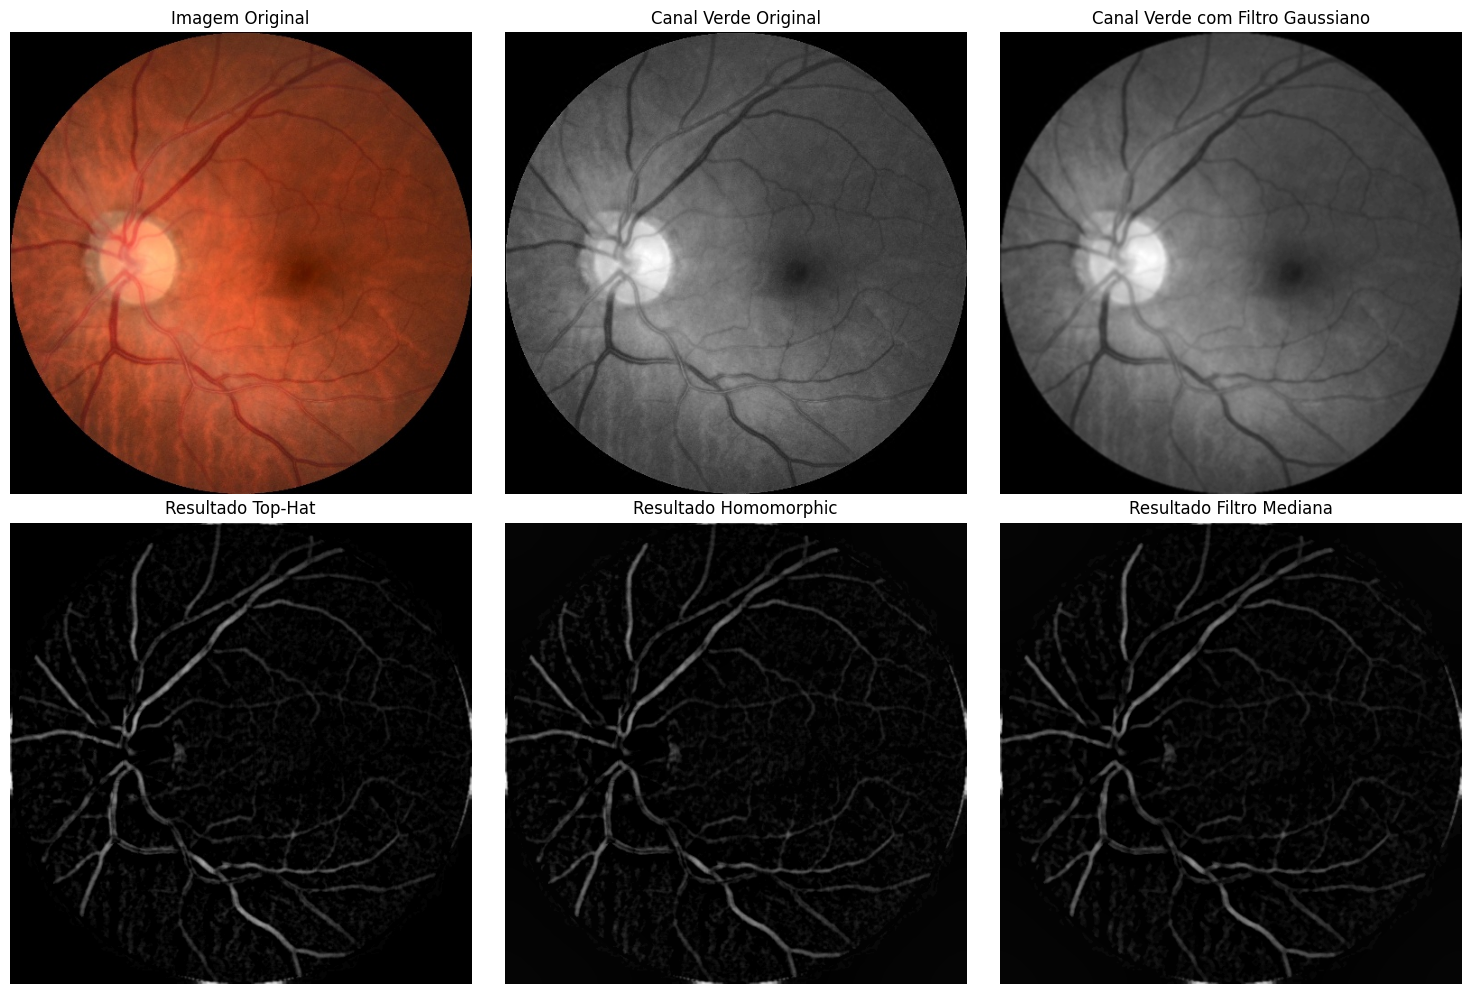

Imagem combinada salva como: thick_vessels_processed.jpg


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Caminho da imagem
image_path = "fundus_image.jpg"

try:

    original_img = get_image(image_path)
    
    # Extração e processamento da imagem
    green_channel = extract_green_channel(image_path)

    # Aplica o filtro Gaussiano no canal verde
    filtered_green_channel = apply_gaussian_filter_to_image(green_channel, kernel_size=5, sigma=1)

    # TOP-hat
    top_hat_result = optimized_top_hat(filtered_green_channel)

    # Homomorphic Filter
    homomorphic_result = homomorphic_filtering(top_hat_result, sigma=2.0)

    #Filtro mediana
    median_result = median_filter(homomorphic_result, kernel_size=3)

    #Novamente, filtro TOP_HAT
    top_hat_result_final = optimized_top_hat(median_result)
    # Criação de uma única imagem com todas as etapas
    images = [
        (original_img, "Imagem Original"),
        (green_channel, "Canal Verde Original"),
        (filtered_green_channel, "Canal Verde com Filtro Gaussiano"),
        (top_hat_result, "Resultado Top-Hat"),
        (homomorphic_result, "Resultado Homomorphic"),
        (median_result, "Resultado Filtro Mediana"),
    ]

    # Configuração da grade de subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for ax, (image, title) in zip(axes.ravel(), images):
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    # Ajustar layout e salvar a imagem
    plt.tight_layout()
    output_path = "thick_vessels_processed.jpg"
    plt.savefig(output_path, dpi=300)
    plt.show()

    print(f"Imagem combinada salva como: {output_path}")

except FileNotFoundError as e:
    print(e)


# Segmentations of thin vessels

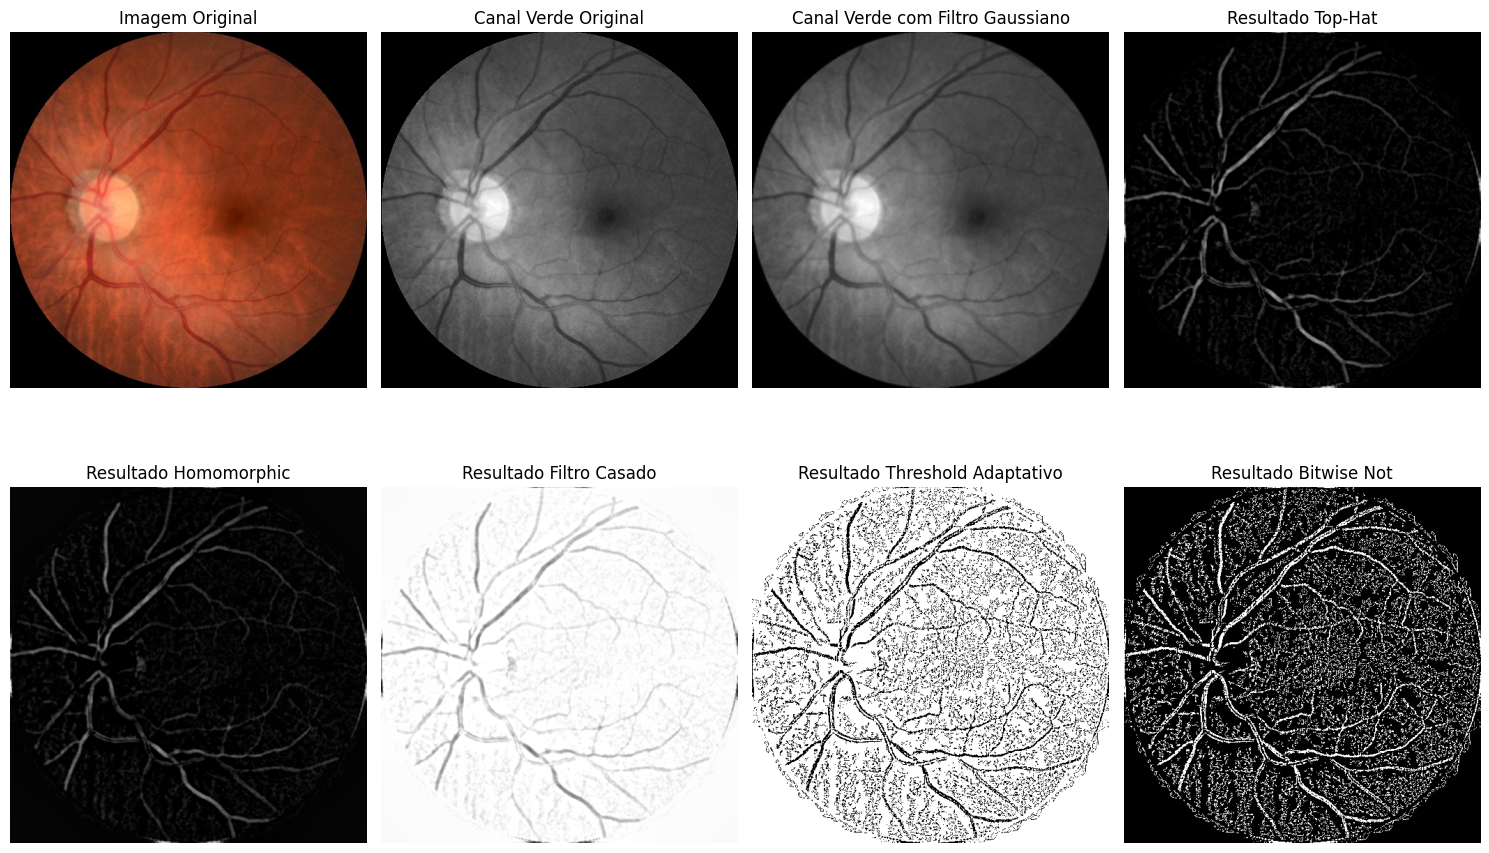

Imagem combinada salva como: thin_vessels_processed.jpg


In [4]:
# Caminho da imagem
image_path = "fundus_image.jpg"

try:
    original_img = get_image(image_path)
    
    green_channel = extract_green_channel(image_path)

    # Aplica o filtro Gaussiano no canal verde
    filtered_green_channel = apply_gaussian_filter_to_image(green_channel, kernel_size=5, sigma=1)

    # TOP-hat
    top_hat_result = optimized_top_hat(filtered_green_channel)

    # Homomorphic Filter
    homomorphic_result = homomorphic_filtering(top_hat_result, sigma=2.0)

    #Filtro Matched
    matched_result = apply_matched_filter(homomorphic_result,size=1, sigma=0.4)

    thresholded_image = adaptive_threshold(matched_result)

    inverted_image = invert_image(thresholded_image)



    
    images = [
        (original_img, "Imagem Original"),
        (green_channel, "Canal Verde Original"),
        (filtered_green_channel, "Canal Verde com Filtro Gaussiano"),
        (top_hat_result, "Resultado Top-Hat"),
        (homomorphic_result, "Resultado Homomorphic"),
        (matched_result, "Resultado Filtro Casado"),
        (thresholded_image, "Resultado Threshold Adaptativo"),
        (inverted_image, "Resultado Bitwise Not"),
    ]

    # Configuração da grade de subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))
    for ax, (image, title) in zip(axes.ravel(), images):
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    # Ajustar layout e salvar a imagem
    plt.tight_layout()
    output_path = "thin_vessels_processed.jpg"
    plt.savefig(output_path, dpi=300)
    plt.show()

    print(f"Imagem combinada salva como: {output_path}")

except FileNotFoundError as e:
    print(e)


# Morfological Operation

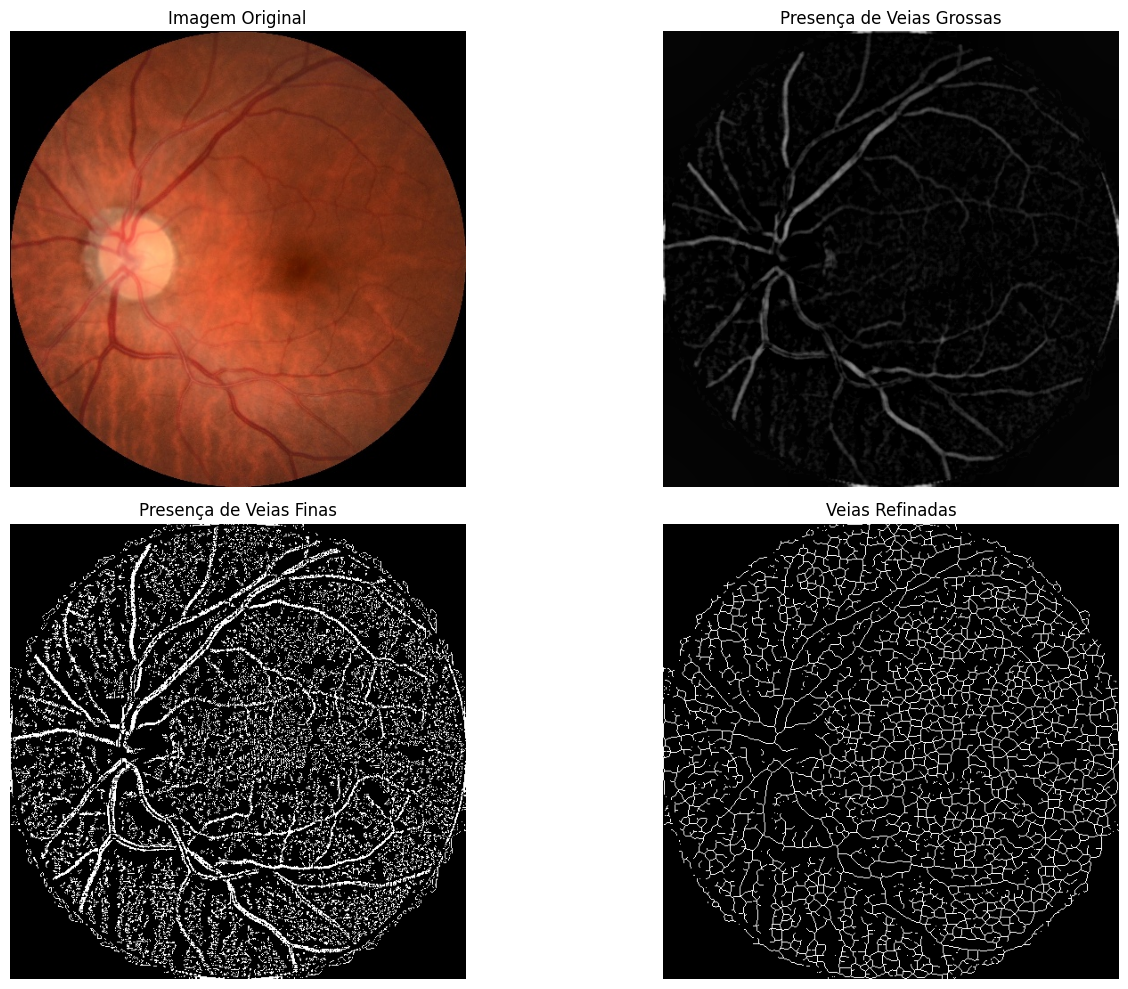

Imagem combinada salva como: refined.jpg


In [5]:
thick_vessels, thin_vessels = homomorphic_result, inverted_image

image_path = "fundus_image.jpg"

original_img = get_image(image_path)

# Combinar veias grossas e finas
combined_vessels = combine_vessels(thick_vessels, thin_vessels)

# Refinar o resultado combinado
refined_vessels = refine_combined_vessels(combined_vessels)

images = [
    (original_img, "Imagem Original"),
    (homomorphic_result, "Presença de Veias Grossas"),
    (inverted_image, "Presença de Veias Finas"),
    (refined_vessels, "Veias Refinadas"),
]

# Configuração da grade de subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, (image, title) in zip(axes.ravel(), images):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Ajustar layout e salvar a imagem
plt.tight_layout()
output_path = "refined.jpg"
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Imagem combinada salva como: {output_path}")